# datatools

> Module to handle loading, preprocessing and postprocessing of point cloud data.

In [ ]:
#| default_exp datatools

In [ ]:
#| export
import torch
from torch.utils.data import Dataset
from torch import nn
import yaml
from pathlib import Path
import numpy as np
from torchvision.transforms import v2

In [ ]:
#| export
class SemanticKITTIDataset(Dataset):
    "Load the SemanticKITTI data in a pytorch Dataset object. The data is not downloaded automatically."
    def __init__(self, data_path):
        data_path = Path(data_path)
        yaml_path = data_path/"semantic-kitti.yaml"
        self.velodyne_path = data_path/"velodyne"
        self.labels_path = data_path/"labels"
        
        velodyne_fns = list(self.velodyne_path.glob('*.bin'))
        self.frame_ids = [fn.stem for fn in velodyne_fns]
        
        with open(yaml_path, 'r') as file:
            metadata = yaml.safe_load(file)
        
        self.labels_dict = metadata.get('labels', {})
        self.learning_map = metadata.get('learning_map', {})
        self.learning_map_inv = metadata.get('learning_map_inv', {})
        self.color_map_bgr = metadata.get('color_map', {})
        
        self.transform = None

    def set_transform(self, transform):
        self.transform = transform
    
    def __len__(self):
        return len(self.frame_ids)

    def __getitem__(self, idx):
        frame_id = self.frame_ids[idx]
        
        frame_path = self.velodyne_path/(frame_id + '.bin')
        with open(frame_path, 'rb') as f:
            frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
        frame = torch.from_numpy(frame)
        
        label_path = self.labels_path/(frame_id + '.label')
        with open(label_path, 'rb') as f:
            label = np.fromfile(f, dtype=np.uint32)
            label = label & 0xFFFF
        label = np.vectorize(self.learning_map.get)(label)
        label = torch.from_numpy(label).int()
        
        if self.transform:
            frame, label = self.transform(frame, label)
        
        return frame, label

Here is an example on how to use it:

In [ ]:
#| eval: false
data_path = '../../Cloud2DImageConverter/point_clouds/semantic_kitti/'
ds = SemanticKITTIDataset(data_path)
ds[0]

(tensor([[78.5171, 14.2679,  2.9050,  0.0000],
         [78.2345, 14.8529,  2.8988,  0.0000],
         [77.7629, 15.0169,  2.8838,  0.0000],
         ...,
         [ 3.8051, -1.4181, -1.7452,  0.2400],
         [ 3.8345, -1.4161, -1.7572,  0.3000],
         [ 3.8348, -1.4031, -1.7562,  0.0000]]),
 tensor([0, 0, 0,  ..., 9, 9, 9], dtype=torch.int32))

In [ ]:
#| export
class SphericalProjectionTransform(nn.Module):
    "Pytorch transform that turns a point cloud frame and its respective label into spherical projection images."
    def __init__(self, fov_up_deg, fov_down_deg, W, H):
        super().__init__()
        self.fov_up_rad = (fov_up_deg/180.)*np.pi
        self.fov_down_rad = (fov_down_deg/180.)*np.pi
        self.fov_rad = abs(self.fov_down_rad) + abs(self.fov_up_rad)
        self.W = W
        self.H = H
        
    def forward(self, frame, label):
        # get point_cloud components
        scan_xyz = frame[:,:3]
        reflectance = frame[:, 3]

        # get depths of all points
        depth = torch.norm(scan_xyz, dim=1)
        
        # get angles of all points
        yaw = torch.atan2(scan_xyz[:,1], scan_xyz[:,0])
        pitch = torch.asin(scan_xyz[:,2] / depth)
        
        # get projections in image coords (between [0.0, 1.0])
        proj_x = 0.5 * (yaw / np.pi + 1.0)
        proj_y = (abs(self.fov_up_rad) - pitch)/self.fov_rad

        assert proj_x.min() >= 0.
        assert proj_x.max() <= 1.
        assert proj_y.min() >= 0.
        assert proj_y.min() <= 1.
        
        # scale to image size using angular resolution (between [0.0, W/H])
        proj_x *= self.W
        proj_y *= self.H
        
        # round and clamp to use as indices (between [0, W/H - 1])
        proj_x = torch.floor(proj_x)
        proj_x = torch.clamp(proj_x, 0, self.W - 1).int()
        
        proj_y = torch.floor(proj_y)
        proj_y = torch.clamp(proj_y, 0, self.H - 1).int()
        
        # setup the image tensor
        reflectance_depth_label_img = np.zeros((self.H, self.W, 3))
        reflectance_depth_label_img[proj_y, proj_x] = np.stack((reflectance, depth, label.float()), axis=-1)
        
        # reflectance and depth image
        reflectance_depth_img = torch.from_numpy(reflectance_depth_label_img[:,:,:2])
        # label image
        label_img = torch.from_numpy(reflectance_depth_label_img[:,:,2]).int()
        
        return reflectance_depth_img, label_img

In [ ]:
#| export
class ProjectionVizTransform(nn.Module):
    "Pytorch transform to preprocess sphererical projection images for proper visualization."
    def __init__(self, color_map_bgr, learning_map_inv):
        super().__init__()
        self.color_map_bgr = color_map_bgr
        self.learning_map_inv = learning_map_inv
    
    def forward(self, frame, label):
        
        r = (frame[:,:,0]*255.).int()
        d = (255.*(frame[:,:,1] - frame[:,:,1].min())/(frame[:,:,1].max() - frame[:,:,1].min())).int()
        normalized_frame = torch.stack((r, d), dim=-1)
        
        label = np.vectorize(self.learning_map_inv.get)(label)
        colored_label = np.empty(label.shape + (3,))
        for key, value in self.color_map_bgr.items():
            indices = np.where(label == key)
            colored_label[indices] = value[::-1]
        colored_label = torch.from_numpy(colored_label).int()
        
        return normalized_frame, colored_label

Here is an example on how to compose them with the *torchvision.transforms.v2* module:

In [ ]:
#| eval: false
tfms = v2.Compose([
    SphericalProjectionTransform(fov_up_deg=4., fov_down_deg=-26., W=1024, H=64),
    ProjectionVizTransform(ds.color_map_bgr, ds.learning_map_inv),
])
ds.set_transform(tfms)

img, label = ds[0]

In [ ]:
#| eval: false
from matplotlib import pyplot as plt

<matplotlib.image.AxesImage>

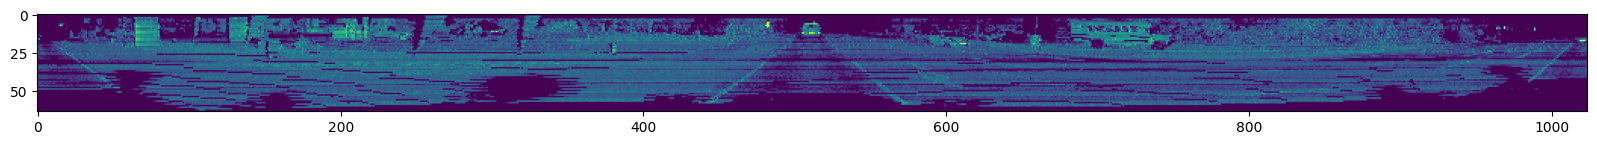

In [ ]:
#| eval: false
plt.figure(figsize=(20,10))
plt.imshow(img[:,:,0])

<matplotlib.image.AxesImage>

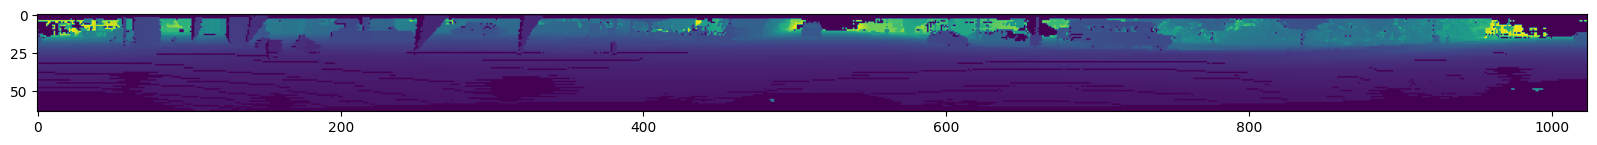

In [ ]:
#| eval: false
plt.figure(figsize=(20,10))
plt.imshow(img[:,:,1])

<matplotlib.image.AxesImage>

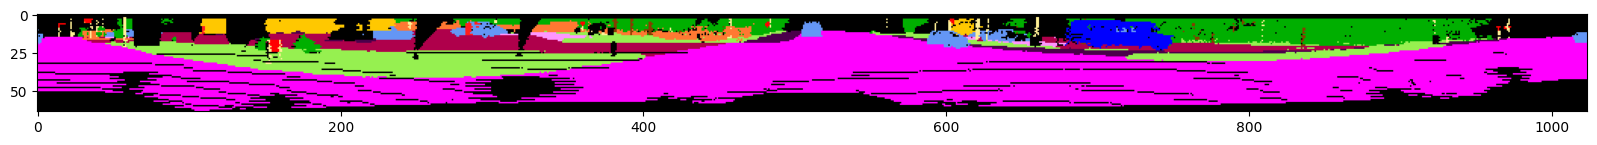

In [ ]:
#| eval: false
plt.figure(figsize=(20,10))
plt.imshow(label)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()